## K-means clustering with PCA

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 4000
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../.')
from lib import get_data

In [172]:
df = get_data.get_model_data(date_range=(0,7), pred_day=10)

# select only numeric data, drop fips column, drop rows with NA
dfnum_with_index = df._get_numeric_data().drop(['fips'],axis=1).dropna()

# Standardize the data
scaler = preprocessing.StandardScaler()
dfnum = pd.DataFrame(scaler.fit_transform(dfnum_with_index), columns=dfnum_with_index.columns)

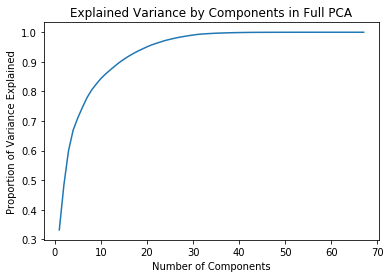

In [173]:
# employed PCA to reduce the number of features as well as the noise in our data set. 
full_pca = PCA(random_state=109).fit(dfnum)

# Calculate the cumulative sum of the variance explained by each component.
cum_exp_var = np.cumsum(full_pca.explained_variance_ratio_)
plt.plot(np.arange(len(cum_exp_var))+1, cum_exp_var)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Explained Variance by Components in Full PCA');

In [174]:
cum_exp_var_df = pd.DataFrame([cum_exp_var], columns=np.arange(len(cum_exp_var))+1, index=['Variance Explained'])
cum_exp_var_df.columns.name = 'Number of PCs'
cum_exp_var_df

Number of PCs,1,2,3,4,5,6,7,8,9,10,...,58,59,60,61,62,63,64,65,66,67
Variance Explained,0.33218,0.484553,0.599525,0.669112,0.710118,0.745654,0.778691,0.80459,0.824595,0.843261,...,0.999999,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [175]:
# choose the number of components cover 80% of variance --> n_components = 8
final_pca = PCA(8, random_state=109).fit(dfnum)
dfnum_pca = final_pca.transform(dfnum)

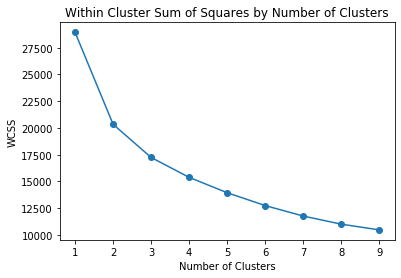

In [176]:
# cross validate number of clusters
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=109).fit(dfnum_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10), wcss,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Within Cluster Sum of Squares by Number of Clusters');

In [177]:
# elbow method --> n_clusters = 4
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=109).fit(dfnum_pca)

In [178]:
dfnum_pca_kmeans = pd.concat([dfnum.reset_index(drop = True),pd.DataFrame(dfnum_pca)],axis =1)
dfnum_pca_kmeans.columns.values[-4:] = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4']
dfnum_pca_kmeans['Kmeans Cluster'] = kmeans_final.labels_
dfnum_pca_kmeans.head()

,cases,deaths,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,...,day_10_delta_deaths,0,1,2,3,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Kmeans Cluster
0,-0.519417,-0.025768,-0.968423,-0.582393,0.235206,0.883918,0.968625,1.065056,1.160095,1.285567,...,-0.497416,5.856374,2.324635,-0.663894,0.152439,-0.226930,-0.503658,-0.695674,-0.217274,2
1,-0.512901,0.541658,-0.961487,-0.550729,0.370467,0.527934,0.561149,0.666038,0.848662,0.885000,...,-0.497416,4.110932,3.000520,-1.152254,-0.191781,0.588828,-0.996618,-0.300914,-0.179673,0
2,-0.871275,-0.593195,-0.940677,-0.602749,0.526537,0.344290,0.424066,0.567760,0.593281,0.728841,...,-0.497416,3.574087,3.179112,-0.820523,-0.784834,0.631670,-1.238587,-0.097668,-0.718468,0
3,-0.050274,2.385795,-0.968423,-0.969155,-0.590234,0.780710,0.749360,0.685908,0.642405,0.891259,...,1.211146,4.817810,3.193035,-4.273034,-1.180483,-0.569624,-0.597240,0.990040,1.305678,0
4,-0.382584,0.541658,-0.968423,-0.487399,0.755441,1.138496,1.223919,1.324982,1.438778,1.495865,...,-0.497416,7.049329,3.283710,-1.603097,-0.668563,-0.230361,-0.965875,-1.586521,1.461136,2


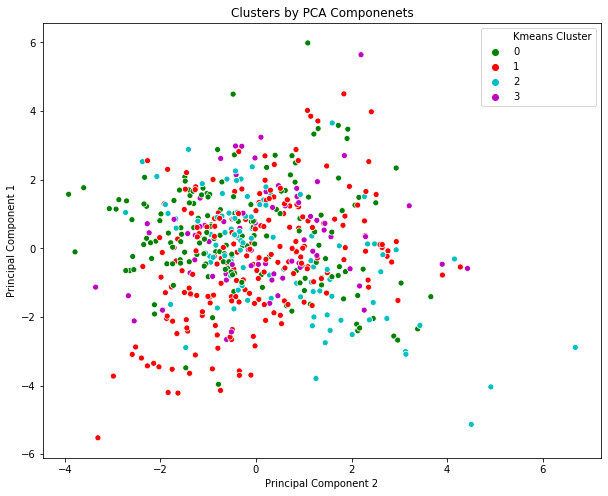

In [179]:
x_axis = dfnum_pca_kmeans['Principal Component 2']
y_axis = dfnum_pca_kmeans['Principal Component 1']
plt.figure(figsize =(10,8))
sns.scatterplot(x_axis, y_axis, hue = dfnum_pca_kmeans['Kmeans Cluster'], palette = ['g','r','c','m'])
plt.title('Clusters by PCA Componenets')
plt.show()

In [208]:
# what counties are in each cluster?
def county_clusters(df = df, df_with_index = dfnum_with_index, kmeans_final = kmeans_final, n_clusters =4, n_counties = 10):
    df = df.iloc[df_with_index.index]
    df['Kmeans Cluster'] = kmeans_final.labels_
    df['state_county'] = df.county +', ' +df.state
    mylist = []
    cluster_names = []
    for i in range(0, n_clusters):
        cluster = df[df['Kmeans Cluster']==i].sort_values(by=['cases'],ascending=False).state_county[0:n_counties].values
        cluster_names.append('Cluster ' + str(i))
        mylist.append(list(cluster))
    county_cluster = pd.DataFrame(mylist)
    county_cluster = county_cluster.transpose()
    county_cluster.columns = cluster_names
    return county_cluster
county_clusters()

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,"maricopa, arizona","wayne, michigan","miami-dade, florida","westchester, new york"
1,"san diego, california","providence, rhode island","travis, texas","el paso, colorado"
2,"mecklenburg, north carolina","macomb, michigan","dougherty, georgia","weld, colorado"
3,"fulton, georgia","orange, new york","charleston, south carolina","benton, washington"
4,"hamilton, ohio","oakland, michigan","hillsborough, florida","pima, arizona"
5,"st. charles, missouri","ocean, new jersey","denton, texas","san bernardino, california"
6,"clark, nevada","carroll, maryland","tarrant, texas","larimer, colorado"
7,"kern, california","union, new jersey","palm beach, florida","lubbock, texas"
8,"bartow, georgia","milwaukee, wisconsin","broward, florida","middlesex, massachusetts"
9,"durham, north carolina","shelby, tennessee","richland, south carolina","canyon, idaho"


In [211]:
variable_contributes = pd.DataFrame(final_pca.components_,columns=dfnum.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8'])
variable_contributes

,cases,deaths,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,...,retail_and_recreation_percent_change_from_baseline,residential_percent_change_from_baseline,workplaces_percent_change_from_baseline,transit_stations_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,income_2018,pop_2018,day_10_delta_cases,day_10_delta_deaths
PC-1,-0.036649,-0.013596,-0.049578,-0.061420,-0.047327,0.199834,0.202730,0.202559,0.210109,0.211668,...,0.026999,-0.036118,0.025052,0.016397,0.005632,-0.088268,-0.050769,0.008127,-0.043034,-0.030586
PC-2,-0.093327,-0.019814,-0.218607,-0.258325,-0.212180,-0.087505,-0.086899,-0.088309,-0.026032,0.014380,...,0.058647,-0.082921,0.032802,0.057099,0.042153,-0.027402,-0.067604,-0.035557,-0.091604,-0.056275
PC-3,-0.056989,-0.046857,0.006369,0.010866,0.035479,-0.021993,-0.012006,-0.004712,-0.005943,0.012624,...,-0.082041,0.080018,-0.078932,-0.003322,-0.071528,-0.012637,-0.065325,-0.101300,-0.066255,-0.063260
PC-4,0.166372,0.015442,-0.091180,-0.067032,-0.022448,-0.037052,-0.022253,-0.001979,0.003883,0.011114,...,0.332649,-0.309498,0.348761,0.143545,0.324941,0.084387,0.117404,0.214604,0.227437,0.136547
PC-5,-0.264786,-0.050783,0.061791,0.138521,0.146027,0.031007,0.027278,0.016394,-0.011081,-0.012159,...,0.299793,-0.293749,0.281405,0.349660,0.216951,0.072311,-0.104980,0.071006,-0.249001,-0.225250
PC-6,-0.164909,-0.055844,-0.035043,-0.134457,-0.211266,0.075316,0.040642,-0.001340,-0.011409,-0.048779,...,0.004900,-0.068853,0.080291,-0.094346,-0.034432,-0.131485,0.110341,0.037794,-0.148806,-0.152844
PC-7,0.233384,0.132887,0.134608,0.048994,0.011609,0.003564,-0.003217,-0.014599,0.020692,0.018342,...,0.020276,-0.017500,0.046054,-0.050617,0.045555,-0.182159,0.007622,0.185586,0.191179,0.226768
PC-8,0.235593,0.485286,-0.000412,0.018438,0.008819,0.051034,0.041072,0.024286,0.008453,-0.011646,...,-0.010212,-0.034051,0.008853,0.044138,-0.071131,0.011771,-0.063415,0.111214,0.176559,0.356468


Second Try with features selected by GLM.

In [219]:
glm_variables = ['windSpdMin',
       'cases', 'precip', 'deaths', 'cldCvrMin',
       'parks_percent_change_from_baseline', 'presTendAvg', 'snowfall',
       'snowDepth', 'spcHumMin','grocery_and_pharmacy_percent_change_from_baseline']

In [220]:
df_glm_variable_name = df[glm_variables].dropna()
df_glm = df_glm_variable_name
df_glm.head()

,windSpdMin,cases,precip,deaths,cldCvrMin,parks_percent_change_from_baseline,presTendAvg,snowfall,snowDepth,spcHumMin,grocery_and_pharmacy_percent_change_from_baseline
1,1.487500,20.875,0.102500,0.500,0.0000,-33.500000,1.250000e-02,0.0,0.0,7.250000,-12.500
11,0.729167,21.000,0.049375,1.000,0.0625,41.714286,1.250000e-02,0.0,0.0,6.622917,4.500
12,0.675000,14.125,0.070000,0.000,0.2500,-4.000000,-6.938894e-18,0.0,0.0,6.250000,-4.125
13,0.125000,13.125,0.040000,0.000,0.0000,25.000000,6.938894e-18,0.0,0.0,7.137500,-1.000
14,0.025000,29.875,0.015000,2.625,0.0000,-23.000000,-5.000000e-02,0.0,0.0,7.062500,-3.875


In [221]:
scaler = preprocessing.StandardScaler().fit(df_glm)
df_glm = pd.DataFrame(scaler.fit_transform(df_glm), columns=df_glm.columns)
full_pca_glm = PCA(random_state=109).fit(df_glm)

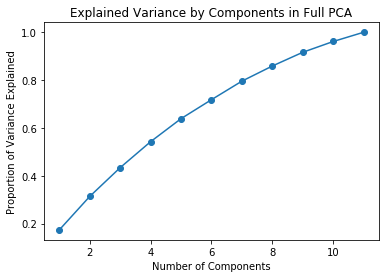

In [222]:
# standardization
scaler = preprocessing.StandardScaler().fit(df_glm)
df_glm = pd.DataFrame(scaler.fit_transform(df_glm), columns=df_glm.columns)

#dimension reducation with PCA
full_pca_glm = PCA(random_state=109).fit(df_glm)

# Calculate the cumulative sum of the variance explained by each component.
cum_exp_var = np.cumsum(full_pca_glm.explained_variance_ratio_)
plt.plot(np.arange(len(cum_exp_var))+1, cum_exp_var,'-o')
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance Explained')
plt.title('Explained Variance by Components in Full PCA');

In [223]:
final_pca_glm = PCA(7, random_state=0).fit(df_glm)
glm_pca = final_pca_glm.transform(df_glm)

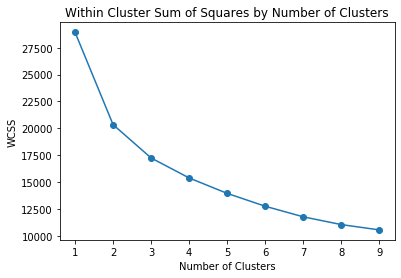

In [224]:
# cross validate number of clusters
wcss = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42).fit(dfnum_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,10), wcss,'-o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Within Cluster Sum of Squares by Number of Clusters');

In [225]:
kmeans_final_glm = KMeans(n_clusters=4, init='k-means++', random_state=109).fit(glm_pca)
glm_pca_kmeans = pd.concat([df_glm.reset_index(drop = True),pd.DataFrame(glm_pca)],axis =1)
glm_pca_kmeans.columns.values[-4:] = ['Principal Component 1','Principal Component 2','Principal Component 3','Principal Component 4']
glm_pca_kmeans['Kmeans Cluster'] = kmeans_final_glm.labels_
glm_pca_kmeans.head()

,windSpdMin,cases,precip,deaths,cldCvrMin,parks_percent_change_from_baseline,presTendAvg,snowfall,snowDepth,spcHumMin,grocery_and_pharmacy_percent_change_from_baseline,0,1,2,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Kmeans Cluster
0,-0.093869,-0.433708,0.143158,-0.015455,-0.910341,-1.172130,0.579711,-0.329461,-0.193476,0.677689,-0.201815,-1.411689,0.530968,0.263495,0.086585,-0.014097,-0.026937,0.501890,1
1,-0.660336,-0.426810,-0.498720,0.569643,-0.903354,1.176928,0.579711,-0.329461,-0.193476,0.447003,1.267927,-0.964961,-1.076649,-1.565038,0.113957,-0.052187,-0.220458,0.358516,2
2,-0.700798,-0.806196,-0.249520,-0.600552,-0.882394,-0.250799,0.316341,-0.329461,-0.193476,0.309818,0.522249,-1.427030,-0.287522,-0.333020,-0.477441,-0.663828,0.124324,0.276326,1
3,-1.111642,-0.861379,-0.611993,-0.600552,-0.910341,0.654915,0.316341,-0.329461,-0.193476,0.636304,0.792422,-1.522346,-0.703053,-0.901663,-0.491927,-0.885086,0.078794,0.130704,1
4,-1.186341,0.062944,-0.914053,2.471208,-0.910341,-0.844199,-0.737141,-0.329461,-0.193476,0.608713,0.543862,-1.066912,-0.012306,-0.872546,2.745537,-0.524998,-0.012679,0.163749,1


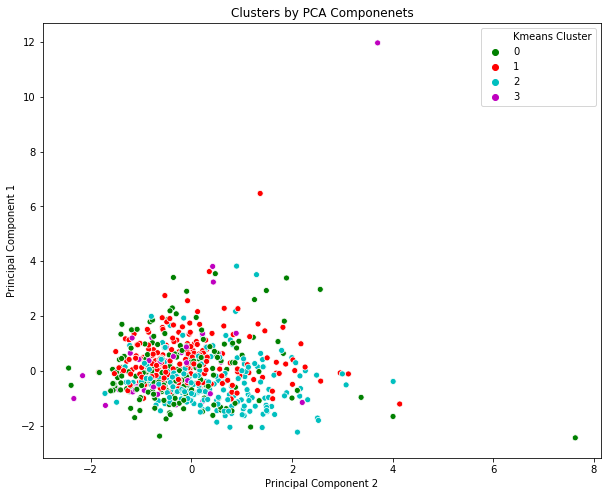

In [226]:
x_axis = glm_pca_kmeans['Principal Component 2']
y_axis = glm_pca_kmeans['Principal Component 1']
plt.figure(figsize =(10,8))
sns.scatterplot(x_axis, y_axis, hue = glm_pca_kmeans['Kmeans Cluster'], palette = ['g','r','c','m'])
plt.title('Clusters by PCA Componenets')
plt.show()

In [227]:
county_clusters(df = df, df_with_index = df_glm_variable_name, kmeans_final = kmeans_final_glm, n_clusters =4, n_counties = 10)


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,"wayne, michigan","miami-dade, florida","maricopa, arizona","onondaga, new york"
1,"providence, rhode island","dougherty, georgia","westchester, new york","king, washington"
2,"macomb, michigan","charleston, south carolina","san diego, california","worcester, massachusetts"
3,"orange, new york","hillsborough, florida","suffolk, new york","dutchess, new york"
4,"oakland, michigan","san bernardino, california","plymouth, massachusetts","denver, colorado"
5,"ocean, new jersey","palm beach, florida","el paso, colorado","boulder, colorado"
6,"carroll, maryland","fulton, georgia","bristol, massachusetts","saratoga, new york"
7,"union, new jersey","kern, california","fairfield, connecticut","ulster, new york"
8,"milwaukee, wisconsin","henry, georgia","essex, new jersey","lake, indiana"
9,"shelby, tennessee","broward, florida","rockland, new york","schenectady, new york"


In [228]:
variable_contributes = pd.DataFrame(final_pca_glm.components_, columns=df_glm_variable_name.columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7'])
variable_contributes

,windSpdMin,cases,precip,deaths,cldCvrMin,parks_percent_change_from_baseline,presTendAvg,snowfall,snowDepth,spcHumMin,grocery_and_pharmacy_percent_change_from_baseline
PC-1,0.132257,0.374529,0.446878,0.130638,0.498632,0.304954,-0.274821,0.303291,0.064956,-0.331717,-0.045512
PC-2,0.197796,0.029459,0.258161,-0.038112,0.364630,-0.372092,-0.261760,-0.348101,-0.351033,0.510519,-0.216692
PC-3,0.193797,-0.351521,-0.068897,-0.119878,0.136468,-0.365187,-0.018303,0.306636,0.462729,-0.123629,-0.586524
PC-4,-0.204914,0.336072,-0.239754,0.715210,-0.112151,-0.211754,-0.290612,-0.073875,0.317365,0.140923,-0.090268
PC-5,0.779524,0.249651,-0.234555,0.202545,0.077492,-0.000247,0.457857,-0.082324,0.052083,0.015588,0.092760
PC-6,0.174119,0.200558,-0.180946,-0.320032,-0.086904,-0.273402,-0.358600,0.533079,0.075022,0.279588,0.464145
PC-7,-0.188991,-0.170972,0.488977,0.162981,0.197976,-0.258994,0.429595,0.041304,0.387575,0.213383,0.425574
